**Author** ::
Muhammad Hassan Mukhtar

**Affiliation** ::
The University of Salford, Manchester, England, UK

**Connect** ::
[GitHub](https://github.com/MHM-Rajpoot)
[LinkedIn](https://www.linkedin.com/in/-muhammad-hassan-mukhtar-/)

In [ ]:
!pip install -q opencv-contrib-python scikit-learn matplotlib tqdm

In [ ]:
import os
import sys
import tarfile
import random
import numpy as np
import cv2
from glob import glob
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

Download Oxford-IIIT Pet Dataset (images only)

In [ ]:
DATA_DIR = '/content/oxford_pets'
os.makedirs(DATA_DIR, exist_ok=True)
images_tar = os.path.join(DATA_DIR, 'images.tar.gz')

if not os.path.exists(images_tar):
    !wget -q -O {images_tar} https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

with tarfile.open(images_tar, 'r:gz') as tar:
    tar.extractall(path=DATA_DIR)

IMG_DIR = os.path.join(DATA_DIR, 'images')
print("Images directory:", IMG_DIR)

/tmp/ipython-input-1656676099.py:11: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=DATA_DIR)


Images directory: /content/oxford_pets/images


In [ ]:
all_imgs = sorted(glob(os.path.join(IMG_DIR, '*.jpg')))

random.seed(42)
sample = random.sample(all_imgs, 200)
len(sample)

200

Helper: Detect keypoints + Descriptors using SIFT (fallback to ORB)

In [ ]:
def get_detector():
    try:
        sift = cv2.SIFT_create()
        return 'SIFT', sift
    except Exception:
        orb = cv2.ORB_create(nfeatures=500)
        return 'ORB', orb

detector_name, detector = get_detector()
print("Using detector:", detector_name)

Using detector: SIFT


Extract Descriptors from the Sample Images (may take a few minutes)

In [ ]:
descriptors_list = []
image_paths = []
failed = 0

for p in tqdm(sample):
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    if img is None:
        failed += 1
        continue
    kp, des = detector.detectAndCompute(img, None)
    if des is None:
        continue
    descriptors_list.append(des)
    image_paths.append(p)

print("Images with descriptors:", len(image_paths), "failed:", failed)

100%|██████████| 200/200 [00:21<00:00,  9.34it/s]

Images with descriptors: 200 failed: 0


Stack Descriptors for Clustering (limit to a maximum for speed)

In [ ]:
all_descriptors = np.vstack(descriptors_list[:200])
print("Stacked descriptors shape:", all_descriptors.shape)

Stacked descriptors shape: (165168, 128)


Build Visual Vocabulary with K-Means (MiniBatchKMeans for speed)

In [ ]:
K = 128
kmeans = MiniBatchKMeans(n_clusters=K, batch_size=1024, random_state=42, verbose=False)
print("Clustering to build a vocabulary (this may take a bit)...")
kmeans.fit(all_descriptors)
vocab = kmeans.cluster_centers_
print("Vocabulary (visual words) built. Shape:", vocab.shape)

Clustering to build a vocabulary (this may take a bit)...
Vocabulary (visual words) built. Shape: (128, 128)


Function to Compute BoVW Histogram for one Image

In [ ]:
def compute_bovw_histogram(img_path, detector, kmeans, K, visualize=False):
    img_color = cv2.imread(img_path)
    img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    kp, des = detector.detectAndCompute(img, None)
    if des is None or len(des)==0:
        hist = np.zeros(K, dtype=np.float32)
        return hist, img_color, kp, None
    labels = kmeans.predict(des)
    hist, _ = np.histogram(labels, bins=np.arange(K+1))
    hist = hist.astype(np.float32)

    # L2 Normalization
    hist = hist / (np.linalg.norm(hist) + 1e-6)

    return hist, img_color, kp, labels

Compute BoVW Histograms for all Images (fast mode: limit to N)

In [ ]:
N = 120
paths_small = image_paths[:N]
hists = []
meta = []
for p in tqdm(paths_small):
    hist, img_color, kp, labels = compute_bovw_histogram(p, detector, kmeans, K)
    hists.append(hist)
    meta.append((p, img_color, kp, labels))

hists = np.vstack(hists)
print("Computed histograms shape:", hists.shape)

100%|██████████| 120/120 [00:13<00:00,  8.58it/s]

Computed histograms shape: (120, 128)


Visualize steps for a single example: Original -> Keypoints -> Patch assignments -> Histogram

In [ ]:
# Cell 11 —
def show_keypoints(img_color, kp, title="Keypoints"):
    img_kp = cv2.drawKeypoints(img_color, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(title)
    plt.show()

def visualize_patch_assignments(img_color, kp, labels, kmeans, patch_size=16, max_patches=200):
    h, w = img_color.shape[:2]
    canvas = img_color.copy()
    cmap = plt.cm.get_cmap('tab20', 20)
    for i, point in enumerate(kp):
        if labels is None: break
        c_idx = int(labels[i] % 20)
        color = tuple((np.array(cmap(c_idx)[:3])*255).astype(int).tolist())
        x, y = int(point.pt[0]), int(point.pt[1])
        cv2.circle(canvas, (x,y), radius=3, color=color[::-1], thickness=-1)
    plt.figure(figsize=(6,6)); plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)); plt.axis('off')
    plt.title("Keypoints colored by visual-word (palette of 20)")
    plt.show()

def show_histogram(hist, title="BoVW histogram"):
    plt.figure(figsize=(6,6))
    colors = plt.cm.get_cmap('tab20', len(hist))
    plt.bar(np.arange(len(hist)), hist, color=colors(np.arange(len(hist)) % 20))
    plt.title(title)
    plt.xlabel("Visual word index")
    plt.ylabel("Normalized frequency")
    plt.show()

Path: /content/oxford_pets/images/Siamese_108.jpg


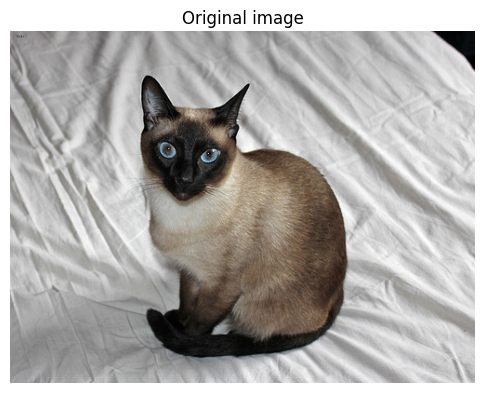

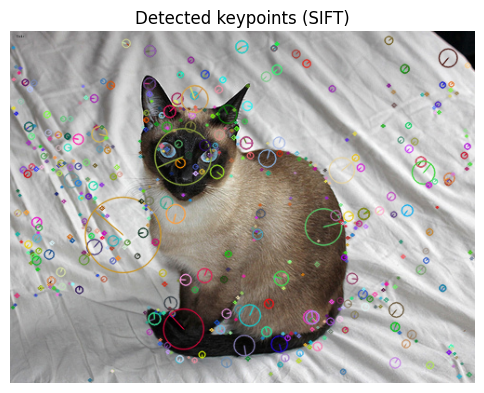

/tmp/ipython-input-2821138968.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', 20)  # 20 distinct colors


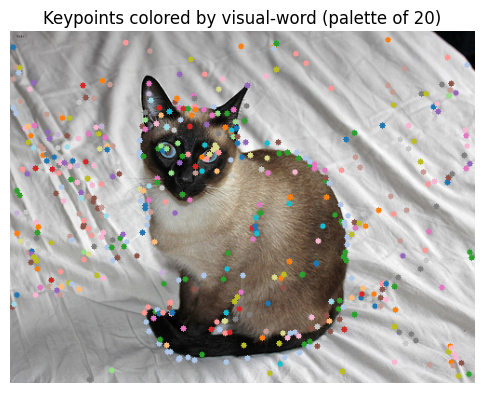

/tmp/ipython-input-2821138968.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(hist))


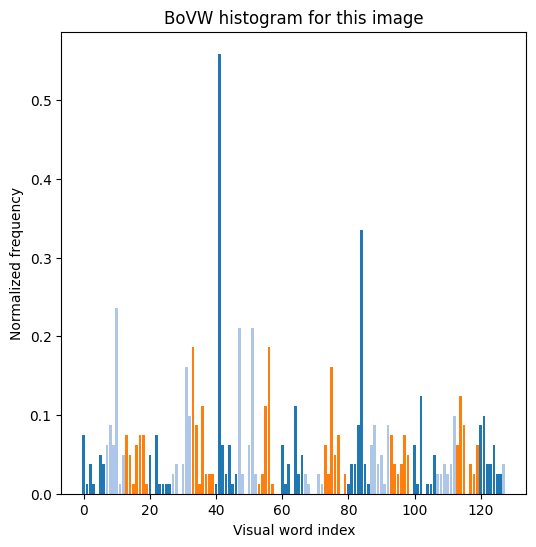

In [ ]:

idx = 5
p, img_color, kp, labels = meta[idx]
print("Path:", p)

# 1) show original
plt.figure(figsize=(6,6)); plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title("Original image"); plt.show()

# 2) show keypoints
show_keypoints(img_color, kp, title=f"Detected keypoints ({detector_name})")

# 3) show keypoints colored by visual word assignment (if labels exist)
visualize_patch_assignments(img_color, kp, labels, kmeans)

# 4) show histogram
show_histogram(hists[idx], title="BoVW histogram for this image")

In [ ]:
def heuristic_label_from_filename(path):
    cat_tokens = ['cat','siam','persian','ragdoll','maine','shorthair','pixie','burmese','british','american','bengal','himalayan']
    base = os.path.basename(path).lower()
    return 1 if any(tok in base for tok in cat_tokens) else 0

labels = np.array([heuristic_label_from_filename(p) for p in paths_small])
X_train, X_test, y_train, y_test = train_test_split(hists, labels, test_size=0.25, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

clf = SVC(kernel='linear', probability=True)
clf.fit(X_train_s, y_train)
print("Train acc:", clf.score(X_train_s, y_train), "Test acc:", clf.score(X_test_s, y_test))

Train acc: 1.0 Test acc: 0.6666666666666666
